In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Load the data set and get the parameters and labels 

In [2]:
temperature_df = pd.read_csv('./data/toronto_temperature.csv')

In [3]:
temperature_df.head(30)

,dt_iso,temp
0,2023-05-17 00:00:00+00:00,15.14
1,2023-05-17 01:00:00+00:00,12.97
2,2023-05-17 02:00:00+00:00,11.63
3,2023-05-17 03:00:00+00:00,10.07
4,2023-05-17 04:00:00+00:00,8.97
5,2023-05-17 05:00:00+00:00,7.95
6,2023-05-17 06:00:00+00:00,6.84
7,2023-05-17 07:00:00+00:00,5.72
8,2023-05-17 08:00:00+00:00,4.43
9,2023-05-17 09:00:00+00:00,3.59


In [4]:
#training_set = temperature_data.iloc[:, 1:2].values

In [5]:
#training_set
temperature_df["temp"] =  temperature_df["temp"].astype(float)

In [6]:
# Feature Scaling
scaler = MinMaxScaler(feature_range = (0, 1))
temperature_df["temp"] = scaler.fit_transform(temperature_df["temp"].values.reshape(-1, 1))
#training_set_scaled = sc.fit_transform()

In [7]:
# Creating a data structure with 168 timesteps and 1 output
# The number 168 is taken because the temperature data is hourly, meaning a day have 24 samples
# For 1 weeks for each step the amount would be calculated 7 * 24 = 168
sequence_length = 168
data = temperature_df["temp"].values
X, y = [], []

for i in range(len(data) - sequence_length):
    X.append(data[i:i+sequence_length])
    y.append(data[i+sequence_length])

#Split the data into training and test sets
X, Y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = Y[:split], Y[split:]

# Preparing the model and building the model

In [8]:
# Model is created, for this case, an LSTM with 84 unit is added with dropout set at 20% of the network
model = Sequential()

#First layer
model.add(LSTM(units = 50, activation="relu" , return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.1))

#Second Layer
model.add(LSTM(units = 50))
model.add(Dropout(0.1))

#Thrid Layer
#model.add(LSTM(units = 120, return_sequences = True))
#model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

# Optimizer and Compiling model
optimizer = Adam(learning_rate=0.001)
#In this LSTM model, the loss function is set to mean squared error and the optimizer is set to adam
#Since the loss function is mean squared error, with omit the metrics and evaluate the model with the loss function
#Close to zero indicates that the model is performing well
model.compile(optimizer = optimizer, loss = 'mean_squared_error')

In [9]:
# Training the model
checkpoint_cb = ModelCheckpoint("./Toronto_Temperature_model.keras", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs = 10,batch_size = 16, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/10
448/448 [==============================] - 35s 73ms/step - loss: 0.0098
Epoch 2/10
448/448 [==============================] - 38s 85ms/step - loss: 0.0028
Epoch 3/10
448/448 [==============================] - 40s 89ms/step - loss: 0.0021
Epoch 4/10
448/448 [==============================] - 35s 78ms/step - loss: 0.0018
Epoch 5/10
448/448 [==============================] - 33s 73ms/step - loss: 0.0017
Epoch 6/10
448/448 [==============================] - 33s 74ms/step - loss: 0.0015
Epoch 7/10
448/448 [==============================] - 35s 78ms/step - loss: 0.0014
Epoch 8/10
448/448 [==============================] - 37s 82ms/step - loss: 0.0011
Epoch 9/10
448/448 [==============================] - 37s 82ms/step - loss: 0.0011
Epoch 10/10
448/448 [==============================] - 40s 90ms/step - loss: 9.8577e-04


In [10]:
model.save("./Toronto_Temperature_model.keras")

In [11]:
# Predict on the test set
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

56/56 [==============================] - 2s 26ms/step


In [12]:
# Calculate metrics
mse = np.mean((predictions - y_test_actual) ** 2)
mae = np.mean(np.abs(predictions - y_test_actual))
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_actual - predictions) / y_test_actual)) * 100

In [13]:
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}%')

MSE: 1.254550610110171
MAE: 0.901838308320519
RMSE: 1.1200672346382476
MAPE: 30.969677961140285%


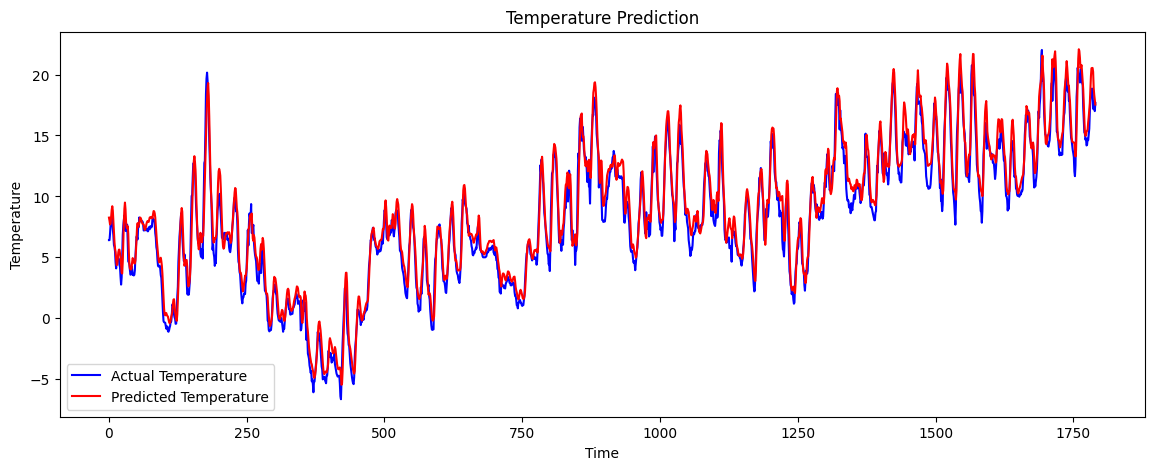

In [14]:
# Plotting predictions vs actual values
plt.figure(figsize=(14, 5))
plt.plot(y_test_actual, color='blue', label='Actual Temperature')
plt.plot(predictions, color='red', label='Predicted Temperature')
plt.title('Temperature Prediction')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

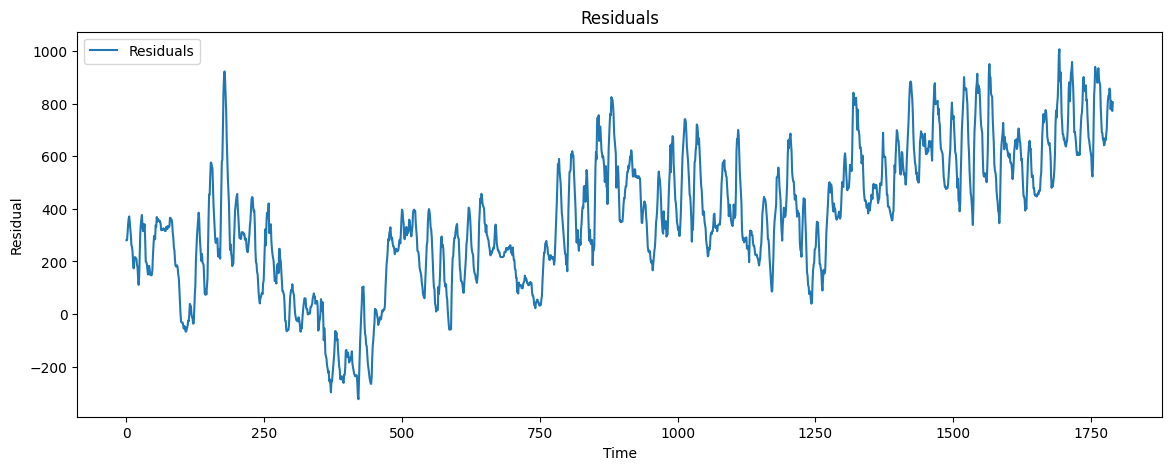

In [22]:
# Residual analysis
residuals = y_test_actual - predictions
plt.figure(figsize=(14, 5))
plt.plot(residuals, label='Residuals')
plt.title('Residuals')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.legend()
plt.show()

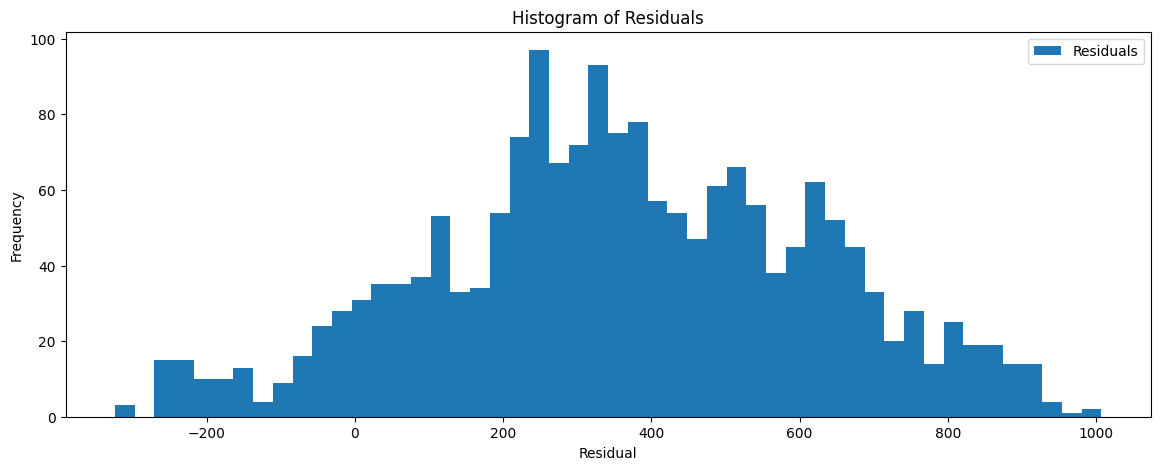

In [23]:
plt.figure(figsize=(14, 5))
plt.hist(residuals, bins=50, label='Residuals')
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.legend()
plt.show()